# Compute multi-model ensemble (NHP1.0)
10th, 50th and 90th percentiles output in a single file.

In [1]:
import xarray as xr
import numpy as np
import lib_david
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
#< Search parameters to filter files included in the MME
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/" # replace with official delivery dir
index = "AI-atmospheric"
index_short = "AI"
gwl = "GWL12" # ["GWL12","GWL15","GWL20","GWL30"]
data_type = "2D"
rcp = "rcp85"
mme_set = ["model","bc"]
quantiles = [0.1, 0.5, 0.9]

# file_out_name =(f"{root_dir}{index}_{data_type}_{gwl}")

In [3]:
def ai_zone_change(da_gwl12, da_gwlx):
    # Define AI categories with intervals and corresponding numerical indices
    ai_categories = {
        5: (-np.inf, 0.05),  # Hyper-Arid
        4: (0.05, 0.2),      # Arid
        3: (0.2, 0.5),       # Semi-Arid
        2: (0.5, 0.65),      # Dry Sub-Humid
        1: (0.65, np.inf)    # Humid
    }
    
    # Function to assign categories based on AI values
    def assign_categories(dataarray, categories):
        categorized = xr.full_like(dataarray, np.inf, dtype=int)
        for index, (lower, upper) in categories.items():
            categorized = categorized.where(~((dataarray >= lower) & (dataarray < upper)), index)
        return categorized
    
    # Categorize AI values for both datasets
    categorized_ai_gwl12 = assign_categories(da_gwl12, ai_categories)
    categorized_ai_gwl30 = assign_categories(da_gwlx, ai_categories)
    
    # Calculate change between the two categorized datasets
    change_map = categorized_ai_gwl12 - categorized_ai_gwl30
    return change_map

### Compute quantiles across models, bc-methods and rcps/ssps (if appliccable)
Upper:  90th percentile = 0.9
Median: 50th percentile = 0.5
Lower:  10th percentile = 0.1

In [ ]:
#< Get files from root directory
files = lib_david.get_file_paths(root_dir,".nc",include=[index,gwl,rcp,data_type],exclude=["percentiles"])
for file in files:
    print(file)
    
# Open files and split file strings for dimension names and add to list from which they are merged across the dimensions specified
da_list = []
for file in files:
    model = file.split('_')[3]
    bc = file.split('_')[-3]
    rcp = file.split('_')[4]
    gwl = file.split('_')[-1][:-3]

    print('Model: '+model, 'BC: '+bc, 'RCP: '+rcp, 'GWL: '+gwl)
    
    da = xr.open_dataset(file)['AI']
    da = da.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
    da_list.append(da)

# Merge data arrays and print output
da_all = xr.merge(da_list)
print(da_all)

In [ ]:
#< Compute quantiles
quantiles = da_all.quantile([0.1,0.5,0.9], dim = mme_set).squeeze()
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Print date and time in the format YYYY-MM-DD HH:MM:SS
#< attach attributes
quantiles.attrs['description'] = f'AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
quantiles.attrs['method']  = 'Using atmospheric-based aridity: pr/e0'
quantiles.attrs['history'] = f"Created on {now}" #cmdprov.new_log(extra_notes=[get_git_hash()])
quantiles.attrs['comment'] = f"Using data on {root_dir}"
quantiles.attrs['models'] = ', '.join(map(str, da_all['model'].data))
quantiles.attrs['GWL'] = f"GWL {float(gwl[-2:])/10}"
quantiles.attrs['RCP'] = f"RCP{float(rcp[-2:])/10}"
quantiles.attrs['bias-correction methods'] = ', '.join(map(str, da_all['bc'].data))
quantiles.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
quantiles.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{gwl}_percentiles10-50-90.nc")

### Plot and check for feasible outcome

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL12_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.5,5])

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL15_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.5,5])

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.5,5])

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL30_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.5,5])

## Compute MME change

In [28]:
#< Import and open pickle file containing models and GWLs to determine matches
import pickle

# Specify the path to your .pkl file
file_path = '/g/data/mn51/users/dh4185/hazards-drought/gwl_years.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    models_gwl = pickle.load(file)


In [29]:
#< Get files from root directory
gwls = ["GWL15","GWL20","GWL30"]
bc_methods = ["r240x120-QME","CSIRO-CCAM-r3355-r240x120-ISIMIP2b","_r240x120-ISIMIP2b","r240x120-MRNBC"]

#< iterate through GWLs 1.5, 2.0, 3.0
for _gwl in gwls:
    print(f"GWL {float(_gwl[-2:])/10}")
    #< Create an empty list to store difference to GWL12
    da_diff_list = []
    diff_pct_da_list = []
    diff_zone_da_list = []
    
    #< iterate through models
    for model in models_gwl:
        
        #< iterate through bc-methods
        for bc in bc_methods:
            
            #< get GWL12 file as reference
            file_gwl12 = lib_david.get_file_paths(root_dir,".nc",include=[index,"GWL12",model,bc,rcp,data_type],exclude=["percentiles"])
            # print(f"GWL1.2 file: {file_gwl12}")
            
            #< ensure there's only one possible file
            if len(file_gwl12)==1:
                da_gwl12 = xr.open_mfdataset(file_gwl12)#[index_short]
            else:
                print(f"There are {len(file_gwl12)} files in the list. Too many to continue.")
                break
        
            print(f"Getting files for {model}, {bc} and {_gwl}")
            file = lib_david.get_file_paths(root_dir,".nc",include=[index,rcp,data_type,model,bc,_gwl],exclude=["percentiles"])
            # print(f"Found: {file}")
            #< ensure there's only one possible file
            if len(file)==1:
                da_gwl = xr.open_mfdataset(file)#[index_short]
            else:
                print(f"There are {len(file)} files in the list. Too many to continue.")
                break
                
            #< calculate difference: GWLx-GWL12
            diff_da = da_gwl - da_gwl12
            diff_da.attrs = da_gwl.attrs
            
            diff_da = diff_da.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
            da_diff_list.append(diff_da)
            
            #< calculate percent change: GWLx/GWL12
            diff_pct_da = ((da_gwl - da_gwl12)/da_gwl12)*100
            diff_pct_da.attrs = da_gwl.attrs
    
            diff_pct_da = diff_pct_da.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
            diff_pct_da_list.append(diff_pct_da)

            #< calculate zone changes
            zone_change = ai_zone_change(da_gwl12,da_gwl)
            zone_change.attrs = da_gwl.attrs

            zone_change = zone_change.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
            diff_zone_da_list.append(zone_change)
    
    # Merge data arrays and print output
    da_diff_all = xr.merge(da_diff_list).squeeze()
    da_diff_pct_all = xr.merge(diff_pct_da_list).squeeze()
    da_zone_change_all = xr.merge(diff_zone_da_list).squeeze()
    

    #< Compute quantiles
    quantiles_diff = da_diff_all.quantile([0.1,0.5,0.9], dim = mme_set).squeeze()
    quantiles_diff_pct = da_diff_pct_all.quantile([0.1,0.5,0.9], dim = mme_set).squeeze()
    quantiles_zone_change = da_zone_change_all.quantile([0.1,0.5,0.9], dim = mme_set,method="closest_observation").squeeze()
    
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Print date and time in the format YYYY-MM-DD HH:MM:SS
    #< attach attributes
    quantiles_diff.attrs['description'] = f'Change of AI at GWL {float(_gwl[-2:])/10} to GWL 1.2 (GWL {float(_gwl[-2:])/10} - GWL 1.2). AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
    quantiles_diff.attrs['method']  = 'Using atmospheric-based aridity: pr/e0'
    quantiles_diff.attrs['history'] = f"Created on {now}" #cmdprov.new_log(extra_notes=[get_git_hash()])
    quantiles_diff.attrs['comment'] = f"Using data on {root_dir}"
    quantiles_diff.attrs['models'] = ', '.join(map(str, da_diff_all['model'].data))
    quantiles_diff.attrs['GWL'] = f"GWL {float(_gwl[-2:])/10}"
    quantiles_diff.attrs['RCP'] = f"RCP{float(rcp[-2:])/10}"
    quantiles_diff.attrs['bias-correction methods'] = ', '.join(map(str, da_diff_all['bc'].data))
    quantiles_diff.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    # quantiles_diff.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_change-to-GWL12_percentiles10-50-90.nc")
    print(quantiles_diff)

    quantiles_diff_pct.attrs = quantiles_diff.attrs
    quantiles_diff_pct.attrs['description'] = f'Percent change of AI at GWL {float(_gwl[-2:])/10} to GWL 1.2 (GWL {float(_gwl[-2:])/10} / GWL 1.2). AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
    quantiles_diff_pct.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_prct-change-to-GWL12_percentiles10-50-90.nc")
    print(quantiles_diff)

    quantiles_zone_change.attrs = quantiles_diff.attrs
    quantiles_zone_change.attrs['description'] = f"Change in aridity zone from GWL 1.2 to GWL {float(_gwl[-2:])/10}. Negative change is a transition to a more arid zone, while a positive change is a transition to a less arid zone. Based on data from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS."
    quantiles_zone_change.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_zone-change-to-GWL12_percentiles10-50-90.nc")
    print(quantiles_zone_change)

GWL 1.5
Getting files for ACCESS1-0, r240x120-QME and GWL15
Getting files for ACCESS1-0, CSIRO-CCAM-r3355-r240x120-ISIMIP2b and GWL15
Getting files for ACCESS1-0, _r240x120-ISIMIP2b and GWL15
Getting files for ACCESS1-0, r240x120-MRNBC and GWL15
Getting files for GFDL-ESM2M, r240x120-QME and GWL15
Getting files for GFDL-ESM2M, CSIRO-CCAM-r3355-r240x120-ISIMIP2b and GWL15
Getting files for GFDL-ESM2M, _r240x120-ISIMIP2b and GWL15
Getting files for GFDL-ESM2M, r240x120-MRNBC and GWL15
Getting files for MIROC5, r240x120-QME and GWL15
Getting files for MIROC5, CSIRO-CCAM-r3355-r240x120-ISIMIP2b and GWL15
Getting files for MIROC5, _r240x120-ISIMIP2b and GWL15
Getting files for MIROC5, r240x120-MRNBC and GWL15
Getting files for CNRM-CM5, r240x120-QME and GWL15
Getting files for CNRM-CM5, CSIRO-CCAM-r3355-r240x120-ISIMIP2b and GWL15
Getting files for CNRM-CM5, _r240x120-ISIMIP2b and GWL15
Getting files for CNRM-CM5, r240x120-MRNBC and GWL15
<xarray.Dataset> Size: 14MB
Dimensions:   (lon: 841,

### Plot and check for feasible outcome

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL15_change-to-GWL12_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile",cmap="RdBu", levels=np.arange(-0.2, 0.25, 0.05))

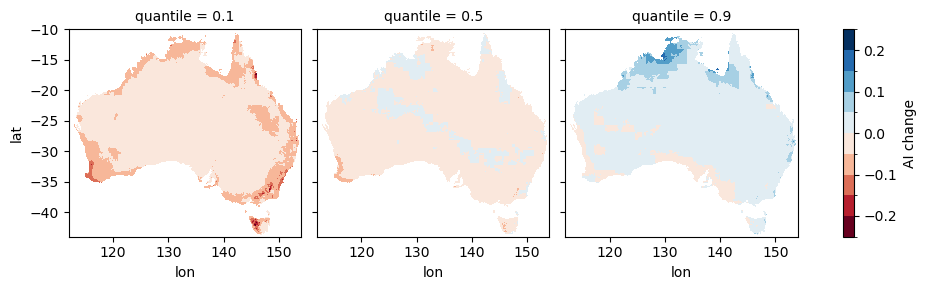

In [3]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_change-to-GWL12_percentiles10-50-90.nc")
quantiles_ds.AI.rename('AI change').plot(col="quantile",cmap="RdBu", levels=np.arange(-0.25, 0.3, 0.05))

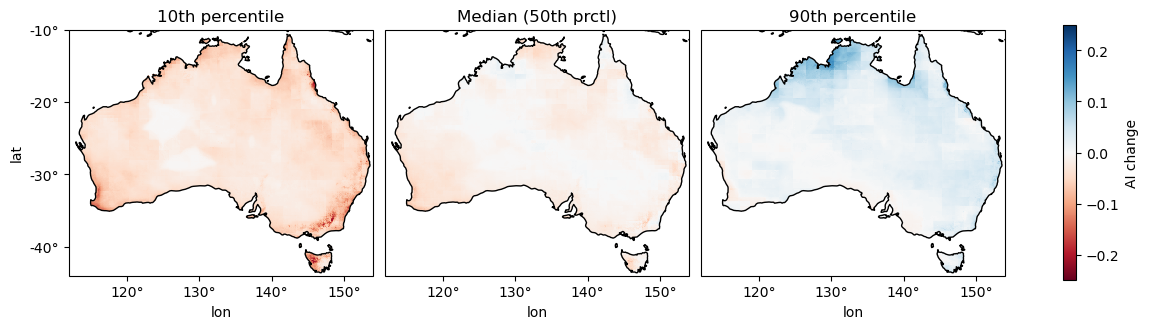

In [5]:
quantiles_ds_prct = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_change-to-GWL12_percentiles10-50-90.nc")

# Define the plot function
def plot_quantiles(dataarray):
    titles = ["10th percentile", "Median (50th prctl)", "90th percentile"]
    p = dataarray.plot(
        col="quantile", 
        cmap="RdBu", 
        # levels=np.arange(-0.275, 0.3, 0.05),
        subplot_kws={"projection": ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(12, 3),  # Adjust the figure size if necessary
        aspect=3  # Adjust aspect ratio if necessary
    )

    # Add coastlines and ticks to each subplot
    for i, ax in enumerate(p.axs.flat):
        ax.coastlines()
        ax.set_xticks(np.arange(-180, 181, 10), crs=ccrs.PlateCarree())
        
        lon_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        lat_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        ax.xaxis.set_major_formatter(lon_formatter)
        
        # Add latitude ticks only to the first subplot
        if i == 0:
            ax.set_yticks(np.arange(-90, 91, 10), crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)

        # Add titles to each subplot
        ax.set_title(titles[i])

    # # Adjust the color bar length
    # p.cbar.set_aspect(20)  # Adjust the aspect ratio of the color bar
    # p.cbar.ax.tick_params(labelsize=10)  # Adjust the tick label size

    plt.show()

# Call the plot function
plot_quantiles(quantiles_ds_prct["AI"].rename("AI change"))

# quantiles_ds_prct_dict = {"10th percentile":quantiles_ds_prct.AI.sel(quantile=0.1),"Median (50th prctl)":quantiles_ds_prct.AI.sel(quantile=0.5),"90th percentile":quantiles_ds_prct.AI.sel(quantile=0.9)}
# lib_david.plot_AI(quantiles_ds_prct_dict,'change_prct','AI (P/PET) relative change (GWL2 to GWL1.2) for NHP1')#,
#        # out_dir+'AI_change_percent_current_plot_BARPA-CMIP6mean.png')

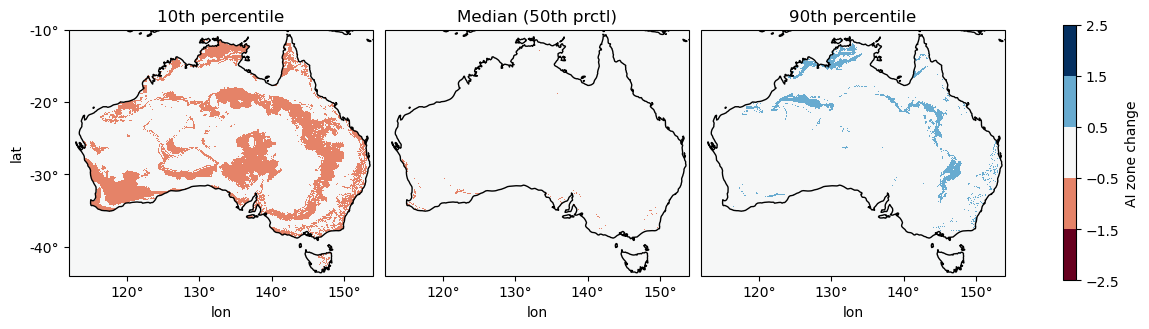

In [39]:
quantiles_ds_zone = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_GWL20_zone-change-to-GWL12_percentiles10-50-90.nc")
# Define the plot function
def plot_quantiles(dataarray):
    titles = ["10th percentile", "Median (50th prctl)", "90th percentile"]
    p = dataarray.plot(
        col="quantile", 
        cmap="RdBu", 
        levels=np.arange(-2.5, 3.5, 1),
        subplot_kws={"projection": ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(12, 3),  # Adjust the figure size if necessary
        aspect=3  # Adjust aspect ratio if necessary
    )

    # Add coastlines and ticks to each subplot
    for i, ax in enumerate(p.axs.flat):
        ax.coastlines()
        ax.set_xticks(np.arange(-180, 181, 10), crs=ccrs.PlateCarree())
        
        lon_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        lat_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        ax.xaxis.set_major_formatter(lon_formatter)
        
        # Add latitude ticks only to the first subplot
        if i == 0:
            ax.set_yticks(np.arange(-90, 91, 10), crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)

        # Add titles to each subplot
        ax.set_title(titles[i])

    # # Adjust the color bar length
    # p.cbar.set_aspect(20)  # Adjust the aspect ratio of the color bar
    # p.cbar.ax.tick_params(labelsize=10)  # Adjust the tick label size

    plt.show()
plot_quantiles(quantiles_ds_zone["AI"].rename("AI zone change"))
# quantiles_ds_zone.AI.plot(col="quantile",cmap="RdBu", levels=np.arange(-2.5, 3.5, 1))

In [ ]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL30_change-to-GWL12_percentiles10-50-90.nc")
quantiles_ds.AI.plot(col="quantile",cmap="RdBu", levels=np.arange(-0.3, 0.35, 0.05))

# Test categorie change

In [4]:
import pandas as pd

def ai_zone_change(da_gwl12, da_gwlx):
    # Define AI categories with intervals and corresponding numerical indices
    ai_categories = {
        5: (-np.inf, 0.05),  # Hyper-Arid
        4: (0.05, 0.2),      # Arid
        3: (0.2, 0.5),       # Semi-Arid
        2: (0.5, 0.65),      # Dry Sub-Humid
        1: (0.65, np.inf)    # Humid
    }
    
    # Function to assign categories based on AI values
    def assign_categories(dataarray, categories):
        categorized = xr.full_like(dataarray, np.inf, dtype=int)
        for index, (lower, upper) in categories.items():
            categorized = categorized.where(~((dataarray >= lower) & (dataarray < upper)), index)
        return categorized
    
    # Categorize AI values for both datasets
    categorized_ai_gwl12 = assign_categories(da_gwl12, ai_categories)
    categorized_ai_gwl30 = assign_categories(da_gwlx, ai_categories)
    
    # Calculate change between the two categorized datasets
    change_map = categorized_ai_gwl12 - categorized_ai_gwl30
    return change_map

In [7]:
da_gwl12 = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_CNRM-CM5_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL12.nc")
da_gwlx = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_CNRM-CM5_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL30.nc")

zone_change = ai_zone_change(da_gwl12.AI,da_gwlx.AI)

#< Stats
change_counts = zone_change.to_series().value_counts().sort_index()
print(change_counts)

AI
-2        10
-1     45617
 0    525352
 1      1742
Name: count, dtype: int64


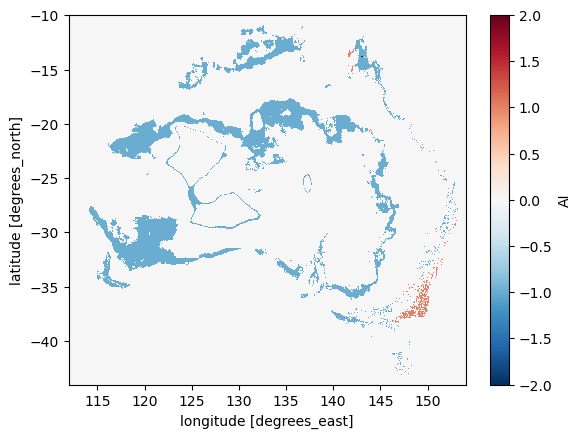

In [6]:
zone_change.plot()

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the changes (optional)
plt.figure(figsize=(12, 6))
sns.heatmap(zone_change, annot=True, fmt='d', cmap='RdBu', center=0)
plt.title('Change in Aridity Zones')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


KeyboardInterrupt

